In [1]:
import calc_footprint_FFP_climatology as myfootprint_s
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import xarray as xr
import shapefile
import rasterio
import cv2
from affine import Affine
from osgeo import gdal
import pygeodesy
import pyproj as proj
import cartopy.crs as ccrs
import traceback
import os
import datetime as dt
import scipy

ModuleNotFoundError: No module named 'pygeodesy'

In [ ]:
in_dir = '/Users/miksch/Thesis_Files/Processed/Eagle_Lake/EL_eb/'
sigv_2017 = os.path.join(in_dir,'ls8_var_2017.csv')
sigv_2018 = os.path.join(in_dir,'ls8_var_2018.csv')
fluxes = os.path.join(in_dir,'ls8_flux.csv')

flux_df = pd.read_csv(fluxes,delim_whitespace=True,parse_dates={'TIMESTAMP':[0,1,2]},date_parser=date_parse,
                      index_col=0,na_values=['*****'])

sigv_df_2017 = pd.read_csv(sigv_2017,delim_whitespace=True,parse_dates={'TIMESTAMP':[0,1]}, date_parser=date_parse_sigv_17,
                           index_col=0,names=['DOY','hrmin','mag_v','sig_v'])
sigv_df_2018 = pd.read_csv(sigv_2018,delim_whitespace=True,parse_dates={'TIMESTAMP':[0,1]}, date_parser=date_parse_sigv_18,
                           index_col=0,names=['DOY','hrmin','mag_v','sig_v'])

sigv_df = pd.concat([sigv_df_2017,sigv_df_2018])
full_df = pd.concat([flux_df,sigv_df],axis=1)
temp_df = full_df[full_df.index.dayofyear == 254].copy()
#full_df.to_csv('filtered_footprint_inputs.csv')
#ls8 = xr.open_dataset('/Users/miksch/Thesis_Files/Processed/landsat/EL_LS8/ls8_v02.nc')

In [49]:
zm_s = 2.78 #Measurement height [m]
h_c = 0.05 #Height of canopy [m]
h_s = 2000. #Height of boundary layer [m]
temp_df['ol'] = zm_s/full_df['z/L'] #Monin-Obukhov length [m]
dx = 3. #Model resolution [m]
origin_d = 600. #Model distance from origin [m]


#Convert local lat/lon to local UTM (Eagle Lake: UTM 12)
station_coord = (-112.050747,41.166695) #Eagle Lake lat/lon 
in_proj = proj.Proj(init='EPSG:4326')
out_proj = proj.Proj(init='EPSG:32612')
(station_x,station_y) = proj.transform(in_proj,out_proj,*station_coord)

new_dat = None

for indx,t in enumerate(temp_df.index):

    print(t)
    hr = t.hour
    
    try:
        
        temp_line = temp_df.loc[t,:]

        temp_ffp = myfootprint_s.FFP_climatology(domain=[-origin_d,origin_d,-origin_d,origin_d],dx=dx,dy=dx,
                                zm=zm_s,z0=h_c*.15,h=h_s,rs=None,
                                ol=temp_line['ol'],sigmav=temp_line['sig_v'],umean=temp_line['V'],
                                ustar=temp_line['ustar'],wind_dir=temp_line['Dir'],
                                crop=0,fig=0,verbosity=0)

        f_2d = np.array(temp_ffp['fclim_2d'])
        x_2d = np.array(temp_ffp['x_2d']) + station_x
        y_2d = np.array(temp_ffp['y_2d']) + station_y
        f_2d = f_2d*dx**2

        #Calculate affine transform for given x_2d and y_2d
        affine_transform = find_transform(x_2d,y_2d)

        if new_dat is None:
            new_dat = rasterio.open('test_footprint.tif','w',driver='GTiff',dtype=rasterio.float64,
                                    count=len(temp_df.index),height=f_2d.shape[0],width=f_2d.shape[1],
                                    transform=affine_transform,
                                    crs='+proj=utm +zone=12 +ellps=WGS84 +datum=WGS84 +units=m +no_defs ',
                                    nodata=0.00000000e+000)

        
    except Exception as e:
        
        print(e)
        print(f'Hour {hr} footprint failed, band {indx+1} not written.')
        
        temp_ffp = None
        
        continue

    #Mask out points that are below a % threshold (defaults to 90%)
    f_2d = mask_fp_cutoff(f_2d)
    
    #Write the new band
    new_dat.write(f_2d,indx+1)
    
    #Update tags with metadata
    tag_dict = {'hour':f'{t.hour*100:04}',
                'wind_dir':temp_line['Dir'],
                'total_footprint':np.nansum(f_2d)}
    new_dat.update_tags(indx+1,**tag_dict)
        
new_dat.close()
new_dat = None
    

2018-09-11 01:00:00

Hour 1 footprint failed, band 1 not written.
2018-09-11 02:00:00
2018-09-11 03:00:00
2018-09-11 04:00:00
2018-09-11 05:00:00

Hour 5 footprint failed, band 5 not written.
2018-09-11 06:00:00

Hour 6 footprint failed, band 6 not written.
2018-09-11 07:00:00

Hour 7 footprint failed, band 7 not written.
2018-09-11 08:00:00
2018-09-11 09:00:00
2018-09-11 10:00:00
2018-09-11 11:00:00
2018-09-11 12:00:00
2018-09-11 13:00:00
2018-09-11 14:00:00
2018-09-11 15:00:00
2018-09-11 16:00:00
2018-09-11 17:00:00
2018-09-11 18:00:00
2018-09-11 19:00:00

Hour 19 footprint failed, band 19 not written.
2018-09-11 20:00:00
2018-09-11 21:00:00

Hour 21 footprint failed, band 21 not written.
2018-09-11 22:00:00

Hour 22 footprint failed, band 22 not written.
2018-09-11 23:00:00


In [50]:

asdf = xr.open_rasterio('test_footprint.tif')

In [63]:
print(asdf.sum(dim=['x','y']))

<xarray.DataArray (band: 23)>
array([0.      , 0.900023, 0.899965, 0.899991, 0.      , 0.      , 0.      ,
       0.900023, 0.900011, 0.90002 , 0.900005, 0.89999 , 0.899998, 0.900012,
       0.899968, 0.899982, 0.900002, 0.900007, 0.      , 0.900008, 0.      ,
       0.      , 0.90002 ])
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 10 ... 14 15 16 17 18 19 20 21 22 23


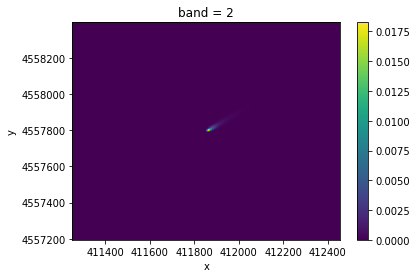

In [52]:
test_band = asdf.sel(band=2)
test_band.plot()